Silhouette Score: 0.8130244173861152


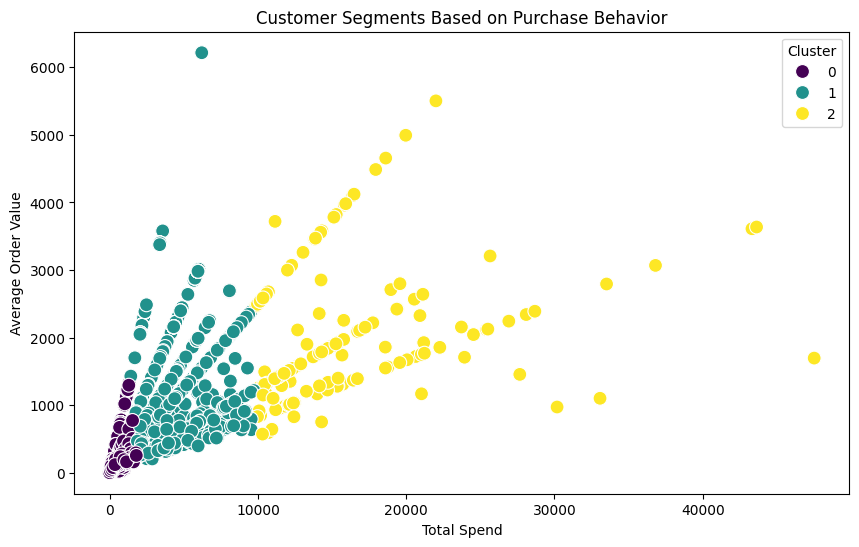

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pyodbc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Hoe kunnen we onze klanten segmenteren op basis van hun aankoopgedrag om marketingstrategieën effectiever af te stemmen?

DB_UnitedOutdoors = {'servername': 'LAPTOP-RJVEH9F7', 'database': 'UnitedOutdoors'}

pyodbc_conn_str = (
    'DRIVER={SQL Server};SERVER=' + DB_UnitedOutdoors['servername'] + 
    ';DATABASE=' + DB_UnitedOutdoors['database'] + ';Trusted_Connection=yes'
)

#SQLAlchemy engine url
connection_url = URL.create(
    "mssql+pyodbc",
    query={"odbc_connect": pyodbc_conn_str}
)

# SQLAlchemy engine
db_connection = create_engine(connection_url)

# Query's 
customers_df = pd.read_sql('SELECT CustomerID, fname, lname FROM Customers', con=db_connection)
orders_df = pd.read_sql('SELECT OrderID, CustomerID, UnitPriceNumber, QuantityNumber FROM [dbo].[Order]', con=db_connection)

# Berekening van totale hoeveelheid gespendeerd + number of order + average order value voor elke customer
orders_df['TotalSpend'] = orders_df['UnitPriceNumber'] * orders_df['QuantityNumber']
customer_orders = orders_df.groupby('CustomerID').agg(
    TotalSpend=pd.NamedAgg(column='TotalSpend', aggfunc='sum'),
    NumOrders=pd.NamedAgg(column='OrderID', aggfunc='count'),
    AvgOrderValue=pd.NamedAgg(column='TotalSpend', aggfunc=lambda x: x.sum() / x.count())
).reset_index()

# df mergen
customer_data = customers_df.merge(customer_orders, on='CustomerID')

# Clusteren met K-means
kmeans = KMeans(n_clusters=3)
customer_data['Cluster'] = kmeans.fit_predict(customer_data[['TotalSpend', 'NumOrders', 'AvgOrderValue']])


#Evaluatie
silhouette_avg = silhouette_score(customer_data[['TotalSpend', 'NumOrders', 'AvgOrderValue']], customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

#visualisatie
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalSpend', y='AvgOrderValue', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments Based on Purchase Behavior')
plt.xlabel('Total Spend')
plt.ylabel('Average Order Value')
plt.show()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_11456\1181451048.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql_query(query, conn)


OrderID                0
QuantityNumber         0
UnitPriceNumber        0
CustomerID             0
EmployeeID             0
ProductID              0
CurrencyRateID     18969
dtype: int64
Accuracy: 0.8930615164520744
Confusion Matrix:
[[2124    0]
 [ 299  373]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2124
           1       1.00      0.56      0.71       672

    accuracy                           0.89      2796
   macro avg       0.94      0.78      0.82      2796
weighted avg       0.91      0.89      0.88      2796



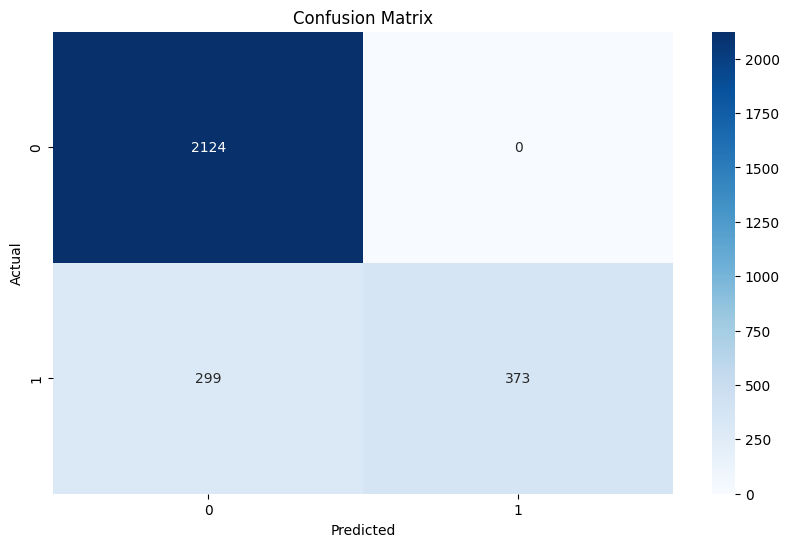

In [3]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


#hoeveel klanten plaatsen een high value order.




DB_UnitedOutdoors = {'servername': 'LAPTOP-RJVEH9F7', 'database': 'UnitedOutdoors'}


pyodbc_conn_str = (
    'DRIVER={SQL Server};SERVER=' + DB_UnitedOutdoors['servername'] + 
    ';DATABASE=' + DB_UnitedOutdoors['database'] + ';Trusted_Connection=yes'
)

conn = pyodbc.connect(pyodbc_conn_str)

# query's
query = """
SELECT 
    OrderID, 
    QuantityNumber, 
    UnitPriceNumber, 
    CustomerID, 
    EmployeeID, 
    ProductID, 
    CurrencyRateID
FROM [Order]
"""
df_orders = pd.read_sql_query(query, conn)

conn.close()


# ontbrekende waardes checker
print(df_orders.isnull().sum())
df_orders = df_orders.dropna()

# nieuw kolom aanmaken
df_orders['TotalPrice'] = df_orders['QuantityNumber'] * df_orders['UnitPriceNumber']

# doelvariabele met een drempelwaarde van 1000)
df_orders['HighValueOrder'] = (df_orders['TotalPrice'] > 1000).astype(int)

# one-hot encoding
df_orders = pd.get_dummies(df_orders, columns=['CustomerID', 'EmployeeID', 'ProductID', 'CurrencyRateID'], drop_first=True)

# Feature en Target selectie + droppen van tabellen
X = df_orders.drop(['OrderID', 'TotalPrice', 'HighValueOrder'], axis=1)
y = df_orders['HighValueOrder']

# Data splitsen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# hyperparameters
model = RandomForestClassifier(n_estimators=139, max_depth=25, random_state=42, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)

# evaluatie
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


EmployeeID                  0
EmployeeFN                  0
EmployeeLN                  0
SalesPersonYTD              0
SalesPersonSalesLastYear    0
dtype: int64


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_11456\3626927049.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


R^2 Score: 0.8105229580686409


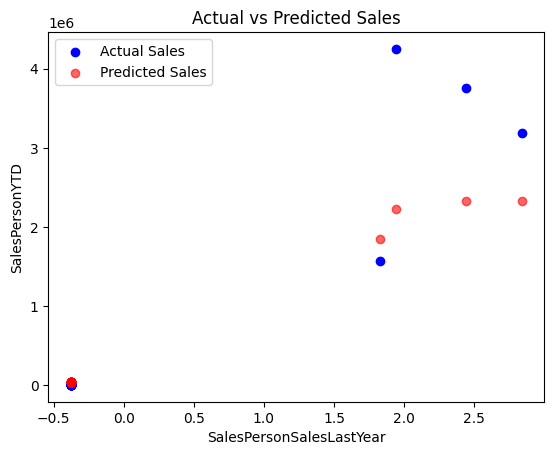

In [4]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt



#hoeveel sales gaan de medewerkers dit jaar maken. Gebaseerd op hun sales van vorig jaar



DB_UnitedOutdoors = {'servername': 'LAPTOP-RJVEH9F7', 'database': 'UnitedOutdoors'}

pyodbc_conn_str = (
    'DRIVER={SQL Server};SERVER=' + DB_UnitedOutdoors['servername'] + 
    ';DATABASE=' + DB_UnitedOutdoors['database'] + ';Trusted_Connection=yes'
)
conn = pyodbc.connect(pyodbc_conn_str)

# query
query = """
SELECT 
    EmployeeID,
    EmployeeFN,
    EmployeeLN,
    SalesPersonYTD,
    SalesPersonSalesLastYear
FROM Employees
"""

#leest data van query
df = pd.read_sql(query, conn)

conn.close()

# nulchecker
print(df.isnull().sum())

# gaan alleen relevante kolommen gebruiken voor regressie
df = df[['SalesPersonYTD', 'SalesPersonSalesLastYear']]
df.dropna(inplace=True)

# new feature
df['SalesGrowth'] = df['SalesPersonYTD'] - df['SalesPersonSalesLastYear']

# Split de data
X = df[['SalesPersonSalesLastYear', 'SalesGrowth']]
y = df['SalesPersonYTD']

# Normaliseer de features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split tde data naar trainingsets en testsets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameters voor randomforestregressor
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],  # Decrease max_depth
    'min_samples_split': [5, 10, 20],  # Increase min_samples_split
    'min_samples_leaf': [4, 8, 12]  # Increase min_samples_leaf
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Blijkbaar het beste model voor gridsearch
best_model = grid_search.best_estimator_

# predictions met test set
y_pred = best_model.predict(X_test)

# Evaluatie
r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2}')

# resultaten
plt.scatter(X_test[:, 0], y_test, color='blue', label='Actual Sales')
plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted Sales', alpha=0.6)
plt.xlabel('SalesPersonSalesLastYear')
plt.ylabel('SalesPersonYTD')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()
